# Assignment 2: Ensemble Methods and Calibration


## Instructions

Please push the .ipynb, .py, and .pdf to Github Classroom prior to the deadline. Please include your UNI as well.

**Make sure to use the dataset that we provide in CourseWorks/Classroom.**

**There are a lot of applied questions based on the code results. Please make sure to answer them all. These are primarily to test your understanding of the results your code generate (similar to any Data Science/ML case study interviews).**


## Name: Jianing Tu
## UNI: jt3363


## Dataset Description: Bank Marketing Dataset

This dataset contains information about direct marketing campaigns (phone calls) of a banking institution. The goal is to predict whether the client will subscribe to a term deposit. The details of the features and target are listed below:

**Features**:
- `age`: Age of the client
- `job`: Type of job
- `marital`: Marital status
- `education`: Education level
- `default`: Has credit in default?
- `balance`: Average yearly balance
- `housing`: Has housing loan?
- `loan`: Has personal loan?
- `contact`: Contact communication type
- `day`: Last contact day of the month
- `month`: Last contact month of year
- `duration`: Last contact duration in seconds
- `campaign`: Number of contacts performed during this campaign
- `pdays`: Number of days since the client was last contacted from a previous campaign
- `previous`: Number of contacts performed before this campaign
- `poutcome`: Outcome of the previous marketing campaign
- `deposit`: Has the client subscribed to a term deposit? (target)

**Objective**: The target variable (`deposit`) is binary (yes/no), and the goal is to predict whether a client will subscribe to a term deposit based on the given features.



In [206]:
## Use this cell to import necessary packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from numpy.linalg import inv
%matplotlib inline
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, TargetEncoder
from sklearn.pipeline import make_pipeline
from sklearn.metrics import make_scorer, accuracy_score, f1_score,recall_score
from sklearn.tree import plot_tree, DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from skopt import gp_minimize
from skopt.space import Integer
from skopt.utils import use_named_args
from sklearn.model_selection import cross_val_score



## Question 1: Decision Trees


**1.1: Load the Bank Marketing Dataset and inspect its structure.**
- Hint: Inspect columns and types.


In [181]:
bank_data = pd.read_csv('bank.csv')
bank_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11162 non-null  int64 
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(7), object(10)
memory usage: 1.4+ MB


In [182]:
bank_data.head()

age         job  marital  education default  balance housing loan  contact  \
0   59      admin.  married  secondary      no     2343     yes   no  unknown   
1   56      admin.  married  secondary      no       45      no   no  unknown   
2   41  technician  married  secondary      no     1270     yes   no  unknown   
3   55    services  married  secondary      no     2476     yes   no  unknown   
4   54      admin.  married   tertiary      no      184      no   no  unknown   

   day month  duration  campaign  pdays  previous poutcome deposit  
0    5   may      1042         1     -1         0  unknown     yes  
1    5   may      1467         1     -1         0  unknown     yes  
2    5   may      1389         1     -1         0  unknown     yes  
3    5   may       579         1     -1         0  unknown     yes  
4    5   may       673         2     -1         0  unknown     yes


**1.2: Are there any missing values in the dataset? If yes, how do you plan to handle them?**


In [183]:
bank_data.isna().sum().sum()

np.int64(0)


**1.3: Plot side-by-side bars of class distribution for each categorical feature in the dataset with respect to the target variable (e.g., `job`, `marital`, `education`, etc.).**


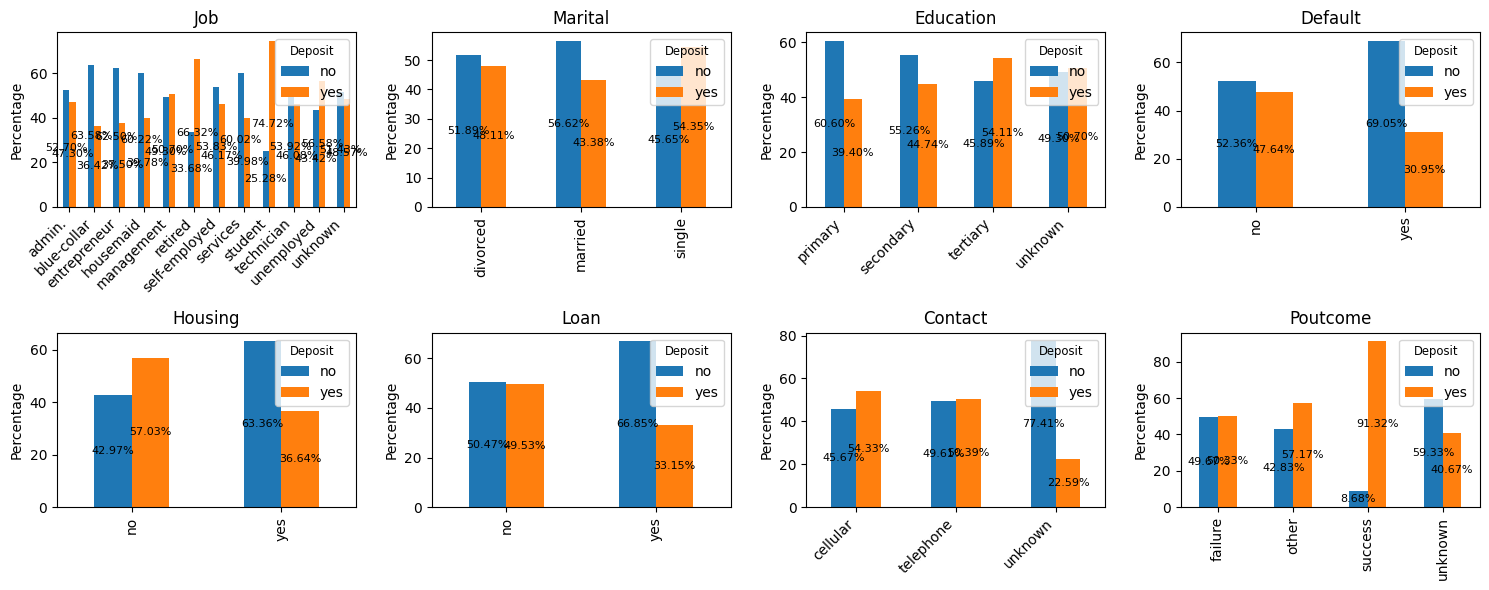

In [184]:
## YOUR CODE HERE
feature_names = bank_data.columns[:-1]
categorical_features_names = [
    "job",
    "marital",
    "education",
    "default",
    "housing",
    "loan",
    "contact",
    "poutcome"
]
fig, ax = plt.subplots(2, 4, figsize=(15, 6))
for cat_feature, ax in zip(categorical_features_names, ax.flatten()):
    ct = pd.crosstab(bank_data[cat_feature], bank_data['deposit'])
    ct_percentage = ct.div(ct.sum(axis=1), axis=0) * 100
    ct_percentage.plot(kind='bar', stacked=False, ax=ax)
    
    ax.set_title(f'{cat_feature.capitalize()}')
    ax.set_xlabel('')
    ax.set_ylabel('Percentage')
    ax.legend(title='Deposit', loc='upper right',title_fontsize='small')
    
    if max([len(str(item.get_text())) for item in ax.get_xticklabels()]) > 8:
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    
    for c in ax.containers:
        ax.bar_label(c, fmt='%.2f%%', label_type='center',fontsize=8)

plt.tight_layout()
plt.show()



**1.4: Explain the distribution of the target variable and the dataset.**


The class distribution looks evenly distributed for each of the categorical variables. The impact of a categorical feature is not that obvious except for 'default' ='yes, 'poutcome' = 'success', 'contact' = 'unknown'.

**1.5: Split the data into development and test datasets. Which splitting methodology did you choose and why?**

**Hint: Based on the distribution of the data, try to use the best splitting strategy.**

I would want to use a gradient classifer since there lacks a strong subset of categorical features that can independently explain the binary classification and everything seems to be working in tendon. Therefore, using residual to boost the tree splitting intuitively feels like a better idea. Among all the gradient classifers, since the dataset is large, dense and full of categorical features, I would like to use a HistGrandientBoostingClassfier. 

In [185]:
## The best strategies for this data set with these many categorical features are ordered target encoding and one-hot encoding.
bank_data_y = (bank_data['deposit'] == 'yes').astype(int)
bank_data_X = bank_data.drop(columns='deposit')
dev_X,  test_X, dev_y, test_y = train_test_split(bank_data_X, bank_data_y, test_size=0.2, random_state=0)

**1.6: Would you drop any column? Justify your reasoning.**

**Preprocess the data (Handle the Categorical Variable). Would you consider a mix of encoding techniques? Justify.
Do we need to apply scaling? Briefly Justify**



In [186]:
## Dropping day and month columnes without specific year there isn't too much information

dev_X.drop(columns=['day', 'month'], inplace=True)
test_X.drop(columns=['day', 'month'], inplace=True)

## I will do both target encoding for features where there is a clear order and one-hot encoding for the rest. I will also apply scaling to the numerical features.

te_features = ["job",'education','contact', 'poutcome']
ohe_features = ['marital', 'default', 'housing', 'loan']
num_features = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']

preprocess = make_column_transformer((StandardScaler(), num_features),
                                     (OneHotEncoder(), ohe_features),
                                     (TargetEncoder(), te_features),remainder='passthrough')

**1.7: Fit a Decision Tree on the development data until all leaves are pure. Which scoring metric will you prefer, and why? What is the performance of the tree on the development set and test set? Evaluate test and train accuarcy on F-1 score and accuracy.**

In [187]:
## YOUR CODE HERE
pipe = make_pipeline(preprocess, DecisionTreeClassifier(criterion='entropy', max_depth=10, random_state=0))
pipe.fit(dev_X, dev_y)
print(f"Train accuracy score: {pipe.score(dev_X, dev_y)}")
print(f"Test accuracy score: {pipe.score(test_X, test_y)}")
print(f"Train F1 score: {f1_score(dev_y, pipe.predict(dev_X))}")   
print(f"Test F1 score: {f1_score(test_y, pipe.predict(test_X))}") 
print(f"Train recall for positive class (1) score: {recall_score(dev_y, pipe.predict(dev_X))}")   
print(f"Test recall for positive class (1) score: {recall_score(test_y, pipe.predict(test_X))}") 


## Since it is for a marketing campaign, the cost of false positive is pretty low, I will index on recall for positive class (1) and precision for negative class (0).


Train accuracy score: 0.8425355582932019
Test accuracy score: 0.7783251231527094
Train F1 score: 0.8424473330345137
Test F1 score: 0.7705146036161336
Train recall for positive class (1) score: 0.882187279981225
Test recall for positive class (1) score: 0.8083657587548638


**1.8: Visualize the trained tree until the suitable max_depth.**

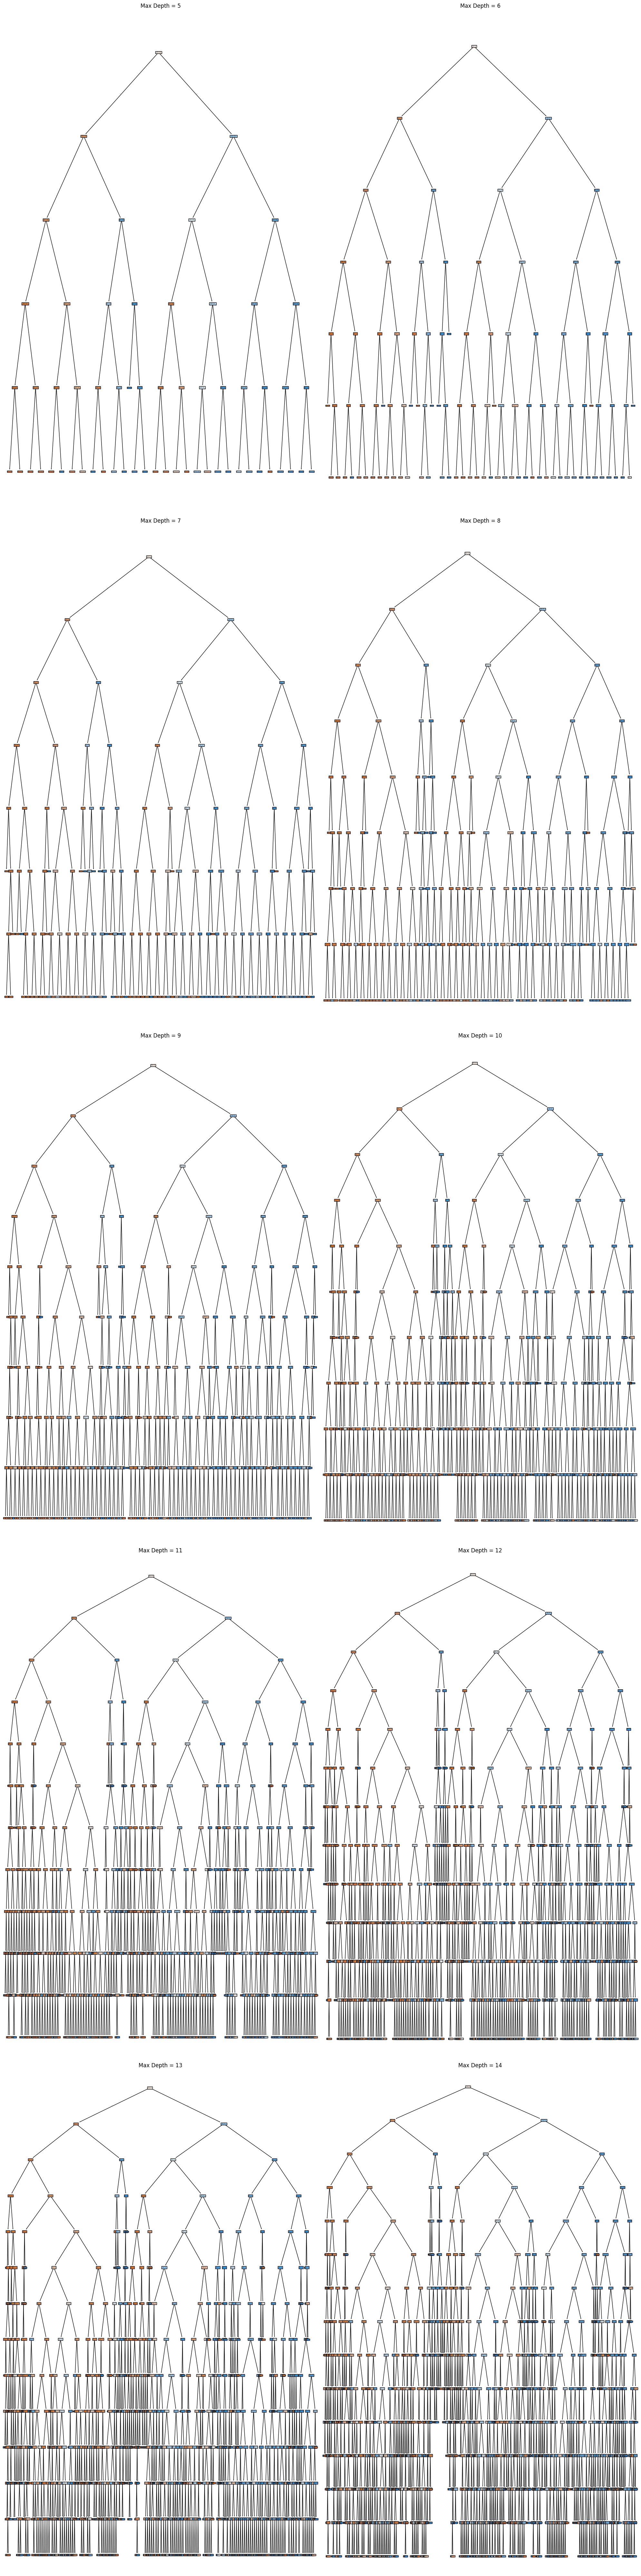

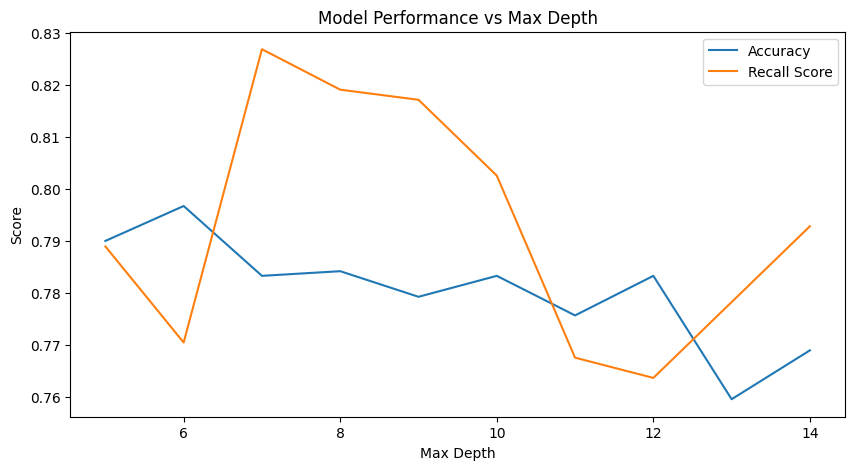

In [188]:

max_depths = range(5, 15) 
recall = []
accuracy = []

plt.figure(figsize=(20, 80))  

for i, depth in enumerate(max_depths):
    
    pipe = make_pipeline(preprocess, DecisionTreeClassifier(criterion='entropy', max_depth=depth, random_state=0))
    pipe.fit(dev_X, dev_y)
    y_pred = pipe.predict(test_X)
    
    recall.append(recall_score(test_y, y_pred))
    accuracy.append(accuracy_score(test_y, y_pred))
    plt.subplot(5, 2, i+1)
    plot_tree(pipe.named_steps['decisiontreeclassifier'], filled=True)
    plt.title(f'Max Depth = {depth}')

plt.tight_layout()
plt.show()

# Plot the metrics
plt.figure(figsize=(10, 5))
plt.plot(max_depths, accuracy, label='Accuracy')
plt.plot(max_depths, recall, label='Recall Score')
plt.xlabel('Max Depth')
plt.ylabel('Score')
plt.title('Model Performance vs Max Depth')
plt.legend()
plt.show()

**1.9: Prune the tree using one of the techniques discussed in class and evaluate the performance.**

**Print the optimal value of the tuned parameter.**

In [189]:
## I will now prune on the cost complexity of the decision tree. I will use the recall score as the metric to optimize for.
ccp_alphas = np.linspace(0, 0.05, 100)
pipe_prune = make_pipeline(preprocess, 
                           RandomizedSearchCV(
                            DecisionTreeClassifier(criterion='entropy', random_state=0,max_depth=8),
                            param_distributions = {'ccp_alpha': ccp_alphas},
                            scoring=make_scorer(recall_score),
                            n_iter=100,
                            )
                           )
pipe_prune.fit(dev_X, dev_y)
random_search_results  = pipe_prune.named_steps['randomizedsearchcv']
best_alpha = random_search_results.best_params_['ccp_alpha']
print(f"Best ccp_alpha: {best_alpha}")

Best ccp_alpha: 0.01616161616161616


**1.10: List the top 3 most important features for this trained tree? How would you justify these features being the most important?**

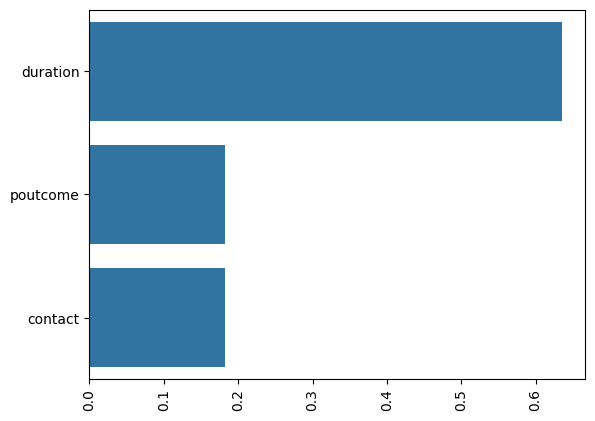

In [190]:
feature_names = num_features + pipe_prune.named_steps['columntransformer'].transformers_[1][1].get_feature_names_out().tolist() + pipe_prune.named_steps['columntransformer'].transformers_[2][1].get_feature_names_out().tolist()
fea_impt = pipe_prune.named_steps['randomizedsearchcv'].best_estimator_.feature_importances_
feat_imps = zip(feature_names, fea_impt)
feats, impts = zip(*sorted((list(filter(lambda x: x[1]!=0, feat_imps))), key=lambda x: x[1], reverse=True))
ax = sns.barplot(x=impts, y=feats)
ax.tick_params(axis='x', rotation=90)

## Question 2: Random Forests

**2.1: Train a Random Forest model on the development dataset using RandomForestClassifier class in sklearn. Use the default parameters. Evaluate the performance of the model on test dataset. Use accuracy and F1 score to evaluate. Does this perform better than Decision Tree on the test dataset (compare to results in Q 1.7)?**

In [191]:
random_forest_pipe = make_pipeline(preprocess, RandomForestClassifier(random_state=0))
random_forest_pipe.fit(dev_X, dev_y)
print(f"Train accuracy score: {random_forest_pipe.score(dev_X, dev_y)}")
print(f"Test accuracy score: {random_forest_pipe.score(test_X, test_y)}")
print(f"Train F1 score: {f1_score(dev_y, random_forest_pipe.predict(dev_X) > 0.5)}")
print(f"Test F1 score: {f1_score(test_y, random_forest_pipe.predict(test_X) > 0.5)}")

#accuracy and f1 are much better than the decision tree model.

Train accuracy score: 0.9399708813976929
Test accuracy score: 0.8150470219435737
Train F1 score: 0.9379485992127807
Test F1 score: 0.8049126121870571


**2.2: Do all trees in the trained random forest model have pure leaves? How would you verify that all trees have pure leaves? Print the score (mean accuracy) values of your choosen method**

In [192]:
## I will check the enthropy of the leave nodes.

forest = random_forest_pipe.named_steps['randomforestclassifier']
enthropies = []
vars = []
for i, estimator in enumerate(forest.estimators_):
    tree = estimator.tree_
    for node_id in range(tree.node_count):
        if tree.children_left[node_id] == tree.children_right[node_id]:  # Leaf node
            samples = tree.n_node_samples[node_id]
            enthropies.append(tree.impurity[node_id])
            variance = np.var(tree.impurity[node_id])
            
print(enthropies) #no impurity in the leaf nodes



[np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.

**2.3: Assume you want to improve the performance of this model. Also, assume that you had to pick two hyperparameters that you could tune to improve its performance. Which hyperparameters would you choose and why?**


I would pick no. of estimator trees, max depth to tune. I would use RandomizedSearchCV to tune the hyperparameters. Depth and estimator trees matter in terms of training cost (time, complexity, computation effort) - I would want to get a good estimate.


**2.4: Now, assume you had to choose up to 5 different values (each) for these two hyperparameters. How would you choose these values that could potentially give you a performance lift?**

If I can only choose 5 values, then I would use Gausian process, since that would give an informed effort to trade-off exploration and explotation within such limited hyperparameter space. I could randomly select 5 pairs oer random search, but using Gausian process because I have not tried this technique and want to see if this can apply.

In [193]:
train_X, val_X, train_y, val_y = train_test_split(dev_X, dev_y, test_size=0.5, random_state=0)

space_vector = [
    [Integer(1, 10, name='max_depth'), Integer(0, 100, name='n_estimators')],
    [Integer(1, 10, name='max_depth'), Integer(200, 300, name='n_estimators')],
    [Integer(1, 10, name='max_depth'), Integer(300, 400, name='n_estimators')],
    [Integer(10, 20, name='max_depth'), Integer(0, 100, name='n_estimators')],
    [Integer(10, 20, name='max_depth'), Integer(200, 300, name='n_estimators')]
]

gp_pipe = make_pipeline(preprocess, RandomForestClassifier(random_state=0))

parameters = []
scores = []
for dimensions in space_vector:

    @use_named_args(dimensions)
    def objective(**params):
        gp_pipe.set_params(randomforestclassifier__max_depth=params['max_depth'],
                        randomforestclassifier__n_estimators=params['n_estimators'])
        return -cross_val_score(gp_pipe, val_X, val_y, cv=3, scoring='recall').mean()


    res = gp_minimize(objective, dimensions, n_calls=10, random_state=0)
    parameters.append(res.x)
    scores.append(-res.fun)

In [194]:
print(f"Best hyperparameters: {parameters}")
print(f"Best scores: {scores}")


Best hyperparameters: [[np.int64(9), np.int64(85)], [np.int64(9), np.int64(285)], [np.int64(8), np.int64(348)], [np.int64(11), np.int64(87)], [np.int64(13), np.int64(265)]]
Best scores: [np.float64(0.8552679499658978), np.float64(0.8533873669851738), np.float64(0.8515094327128733), np.float64(0.8557387578881848), np.float64(0.8571485329466219)]


**2.5: Perform model selection using the chosen values for the hyperparameters. Use out-of-bag (OOB) error for finding the optimal hyperparameters. Report on the optimal hyperparameters. Estimate the performance of the optimal model (model trained with optimal hyperparameters) on train and test dataset? Has the performance improved over your plain-vanilla random forest model trained in Q2.1?**

In [208]:
n_estimators = [x[1] for x in parameters]
max_depths = [x[0] for x in parameters]
oob_scores = {}
train_scores = {}
test_scores = {}

for n_estimator in n_estimators:
    for max_depth in max_depths:
        pipe = make_pipeline(preprocess, RandomForestClassifier(max_depth=max_depth, n_estimators=n_estimator, oob_score=True, random_state=0))
        pipe.fit(dev_X, dev_y)
        train_scores[(n_estimator,max_depth)]= pipe.score(dev_X, dev_y)
        test_scores[(n_estimator,max_depth)] = pipe.score(test_X, test_y)
        oob_scores[(n_estimator,max_depth)] = pipe.named_steps['randomforestclassifier'].oob_score_
    
best_hyperparameters = max(test_scores, key=test_scores.get)
best_pip = make_pipeline(preprocess, RandomForestClassifier(max_depth=best_hyperparameters[1], n_estimators=best_hyperparameters[0], random_state=0))
best_pip.fit(dev_X, dev_y)
print(f"Train accuracy score: {best_pip.score(dev_X, dev_y)}")
print(f"Test accuracy score: {best_pip.score(test_X, test_y)}") 
print(f"Train Recall score: {recall_score(dev_y, best_pip.predict(dev_X))}")
print(f"Test Recall score: {recall_score(test_y, best_pip.predict(test_X))}")
print(f"Train F1 score: {f1_score(dev_y, best_pip.predict(dev_X))}")
print(f"Test F1 score: {f1_score(test_y, best_pip.predict(test_X))}")


(np.int64(85), np.int64(8))
Train accuracy score: 0.8439914884085564
Test accuracy score: 0.8181818181818182
Train Recall score: 0.8666979582257686
Test Recall score: 0.830739299610895
Train F1 score: 0.8413258913315868
Test F1 score: 0.8079470198675497


It is not better for the naive / vanilla random tree 

 **2.6: Can you find the top 3 most important features from the model trained in Q2.5? How do these features compare to the important features that you found from Q1.10? If they differ, which feature set makes more sense?**

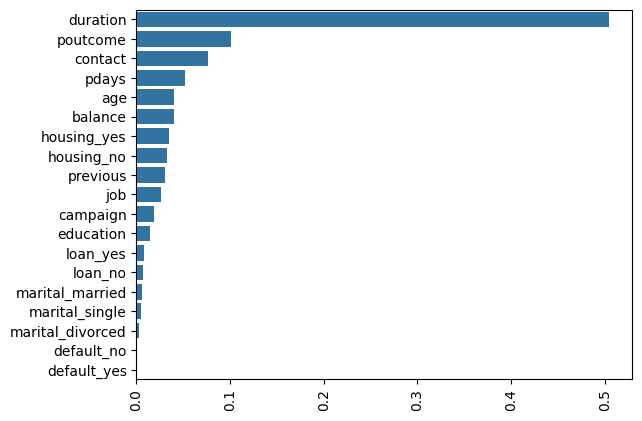

In [202]:
rf = best_pip.named_steps['randomforestclassifier']
feat_imps = list(zip(feature_names, rf.feature_importances_))
feats, imps = zip(*sorted(feat_imps, key=lambda x: x[1], reverse=True))
ax = sns.barplot(x=imps, y=feats)
ax.tick_params(axis='x', rotation=90)

The feature importance is different from 1.10. 1.10 only captured three non-zero importance features which overlaps with rf's ranking which are: duration, poutcome and contact. I think the random forest's feature set makes more sense, based on what I observe from the classification bar charts: other factors play a role.

## Question 3: Gradient Boosted Trees

**3.1: Choose three hyperparameters to tune HistGradientBoostingClassifier on the development dataset using 5-fold cross validation. For each hyperparmeter, give it 3 potential values. Report on the time taken to do model selection for the model. Also, report the performance of the test dataset from the optimal models.**

In [211]:
import time
learning_rate_candidates = [0.1, 0.01, 0.001]
min_samples_leaf_candidats = [20, 30, 40]
max_features_candidates = [0.5, 0.6, 0.7]

train_recall_scores = {}

start_time = time.time()
for learning_rate in learning_rate_candidates:
    for min_samples_leaf in min_samples_leaf_candidats:
        for max_features in max_features_candidates:
            hgbc_pipe = make_pipeline(preprocess, HistGradientBoostingClassifier(random_state=0,learning_rate=learning_rate,min_samples_leaf=min_samples_leaf,max_features=max_features,scoring = 'recall'))
            cv_scores = cross_val_score(hgbc_pipe, dev_X, dev_y, cv=5, scoring='recall')
            mean_cv_score = cv_scores.mean()
            train_recall_scores[(learning_rate, min_samples_leaf, max_features)] = mean_cv_score
    
end_time = time.time()
print(f"Time taken: {end_time - start_time}")

best_index = max(train_recall_scores, key=train_recall_scores.get)
best_pip = make_pipeline(preprocess, HistGradientBoostingClassifier(random_state=0,learning_rate=best_index[0],min_samples_leaf=best_index[1],max_features=best_index[2],scoring = 'recall'))
best_pip.fit(dev_X, dev_y)
print(f"Train accuracy score: {best_pip.score(dev_X, dev_y)}")
print(f"Test accuracy score: {best_pip.score(test_X, test_y)}") 
print(f"Train Recall score: {recall_score(dev_y, best_pip.predict(dev_X))}")
print(f"Test Recall score: {recall_score(test_y, best_pip.predict(test_X))}")
print(f"Train F1 score: {f1_score(dev_y, best_pip.predict(dev_X))}")
print(f"Test F1 score: {f1_score(test_y, best_pip.predict(test_X))}")
    

Time taken: 187.27380084991455
Train accuracy score: 0.8659424347631314
Test accuracy score: 0.8204209583519928
Train Recall score: 0.8838300868340765
Test Recall score: 0.8297665369649806
Train F1 score: 0.8628708901363272
Test F1 score: 0.8096820123398196


**3.2: Repeat 3.1 for XGBoost.**

**Note**: For XGBoost, you **DO NOT HAVE TO** choose the same hyperparameters as HistGradientBoostingClassifier.

In [215]:
max_depths = [5,10,15]
gammas = [0.1, 0.2, 0.3]
subsamples = [0.5, 0.6, 0.7]


train_recall_scores = {}

start_time = time.time()
for max_depth in max_depths:
    for gamma in gammas:
        for subsample in subsamples:
            xgboost_pipe = make_pipeline(preprocess, XGBClassifier(random_state=0,max_depth=max_depth,gamma=gamma,subsample=subsample))
            xgboost_pipe.fit(dev_X, dev_y)
            cv_scores = cross_val_score(xgboost_pipe, dev_X, dev_y, cv=5, scoring='recall')
            mean_cv_score = cv_scores.mean()
            train_recall_scores[(max_depth, gamma, subsample)] = mean_cv_score
    
end_time = time.time()
print(f"Time taken: {end_time - start_time}")

best_index = max(train_recall_scores, key=train_recall_scores.get)
best_pip = make_pipeline(preprocess, XGBClassifier(random_state=0,max_depth=best_index[0],gamma=best_index[2],subsample=best_index[2]))
best_pip.fit(dev_X, dev_y)
print(f"Train accuracy score: {best_pip.score(dev_X, dev_y)}")
print(f"Test accuracy score: {best_pip.score(test_X, test_y)}") 
print(f"Train Recall score: {recall_score(dev_y, best_pip.predict(dev_X))}")
print(f"Test Recall score: {recall_score(test_y, best_pip.predict(test_X))}")
print(f"Train F1 score: {f1_score(dev_y, best_pip.predict(dev_X))}")
print(f"Test F1 score: {f1_score(test_y, best_pip.predict(test_X))}")

Time taken: 45.55834126472473
Train accuracy score: 0.8756859670735805
Test accuracy score: 0.812807881773399
Train Recall score: 0.8904013142454823
Test Recall score: 0.8180933852140078
Train F1 score: 0.8723844561968268
Test F1 score: 0.800952380952381


**3.3: Compare the results on the test dataset of XGBoost and HistGradientBoostingClassifier. Which model do you prefer and why?**

I prefer XGBoost - the performance of XGBoost is slightly better and it takes less time. Seems to be a more efficient algorithm.

**3.4: Can you list the top 3 important features from the trained XGBoost model? How do they differ from the features found from Random Forest and Decision Tree?**

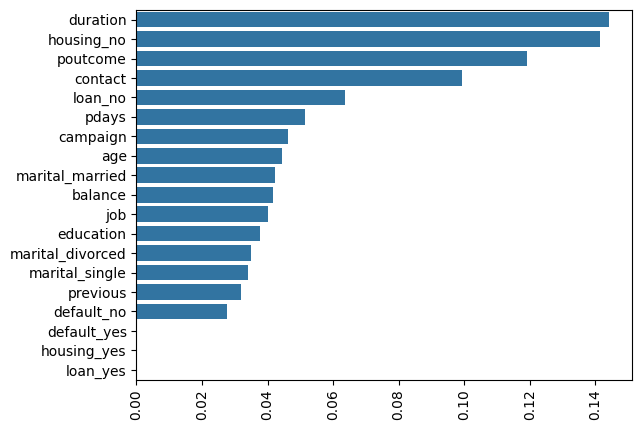

In [216]:
model = best_pip.named_steps['xgbclassifier']
feat_imps = list(zip(feature_names, model.feature_importances_))
feats, imps = zip(*sorted(feat_imps, key=lambda x: x[1], reverse=True))
ax = sns.barplot(x=imps, y=feats)
ax.tick_params(axis='x', rotation=90)

The features are slightly different from the random forest and decision tree. Housing no. becomes the one of the three most important features along side duration and poutcome.

**3.5: Can you choose the top 5 features (as given by feature importances from XGBoost) and repeat Q3.2? Does this model perform better than the one trained in Q3.2? Why or why not is the performance better?**

In [220]:
top_5_features = ['duration','housing','poutcome','contact','loan']

new_data_X = bank_data[list(top_5_features)]
new_data_y = bank_data_y

new_dev_X, new_test_X, new_dev_y, new_test_y = train_test_split(new_data_X, new_data_y, test_size=0.2, random_state=0)


In [221]:
max_depths = [5,10,15]
gammas = [0.1, 0.2, 0.3]
subsamples = [0.5, 0.6, 0.7]


train_recall_scores = {}

start_time = time.time()
for max_depth in max_depths:
    for gamma in gammas:
        for subsample in subsamples:
            xgboost_pipe = make_pipeline(preprocess, XGBClassifier(random_state=0,max_depth=max_depth,gamma=gamma,subsample=subsample))
            xgboost_pipe.fit(dev_X, dev_y)
            cv_scores = cross_val_score(xgboost_pipe, dev_X, dev_y, cv=5, scoring='recall')
            mean_cv_score = cv_scores.mean()
            train_recall_scores[(max_depth, gamma, subsample)] = mean_cv_score
    
end_time = time.time()
print(f"Time taken: {end_time - start_time}")

best_index = max(train_recall_scores, key=train_recall_scores.get)
best_pip = make_pipeline(preprocess, XGBClassifier(random_state=0,max_depth=best_index[0],gamma=best_index[2],subsample=best_index[2]))
best_pip.fit(dev_X, dev_y)
print(f"Train accuracy score: {best_pip.score(dev_X, dev_y)}")
print(f"Test accuracy score: {best_pip.score(test_X, test_y)}") 
print(f"Train Recall score: {recall_score(dev_y, best_pip.predict(dev_X))}")
print(f"Test Recall score: {recall_score(test_y, best_pip.predict(test_X))}")
print(f"Train F1 score: {f1_score(dev_y, best_pip.predict(dev_X))}")
print(f"Test F1 score: {f1_score(test_y, best_pip.predict(test_X))}")

Time taken: 48.44407391548157
Train accuracy score: 0.8749020047037742
Test accuracy score: 0.812807881773399
Train Recall score: 0.8981459751232105
Test Recall score: 0.8278210116731517
Train F1 score: 0.8726485007410786
Test F1 score: 0.8028301886792453


It performs better than 3.2 on test data. With more features added into the classifier, the classifier might be overfitted.